# Simple IST model

$$D_{n+1}=D_n+\lambda(1-D_n)^\beta$$
$$\Delta R_n^{(D)}=\kappa D_n$$

Where
- $\kappa$ is a proportionality constant, can be set to 1
- $D_n\in[0,1]$ (0 = no damage, 1 = failure)
- $\beta \geq 1$ (=1 Miner/Palmgren)
- $\lambda>0$ effective damage rate $[t^{-1}]$

Optional: Arrhenius–Coffin–Manson
$$\lambda = A(|\alpha_{Cu}-\alpha_{lam}|(T_\text{set}-T_\text{ref}))^m \exp{\Bigg(\frac{-Q}{R_gT_\text{set}}\Bigg)}$$

In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.func as F

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib.ticker import ScalarFormatter


# plotting standard settings
plt.rcParams['figure.dpi'] = 360 # standard is 360 but for set to 100 for practical visualization on the notebook
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['figure.figsize'] = (6, 6)
plt.rcParams['lines.linewidth'] = 1.5

In [2]:
class DuctileIST(nn.Module):
    def __init__(self, eps=1e-12):
        super().__init__()
        self.eps = eps

    def forward(self, lam, beta, k_d,
                      N, eps=None):
        eps = eps or self.eps
        batch = lam.size(0)

        # initialise states
        D = lam.new_zeros(batch)
        out = []

        for n in range(int(N)):
            # ---- ductile channel -------------------------------------------------
            one_minus_D = torch.clamp(1. - D, min=eps)
            D = D + lam * one_minus_D.pow(beta)
            
            deltaR = k_d * D
            out.append(deltaR)

        return torch.stack(out, dim=-1)            # [B, N]

## Fracture Term
$$
F_{n+1}=(1+\mu g_n)F_n+\epsilon g_n
$$

- $F_n\in(0,1]$
- $\mu>0$ pole gain
- $g_n(n,n_c,w) = \frac{1}{1+\exp{(-(n-n_c/2))}}$
    - $n_c$ is the pole coordinate
    - $n$ is the cycle, when $n=n_c$, $g_n\to 1$


$$\Delta R_n^{(F)}=\kappa_f F_n$$

with the proportionality constant $\kappa_f$.


In [3]:
class FractureIST(nn.Module):
    def __init__(self, eps=1e-12):
        super().__init__()
        self.eps = eps

    def forward(self, lam, beta, k_d,
                      mu, k_f,
                      n_c, w_t,   # or  D_c, w_D
                      N, eps=None):
        eps = eps or self.eps
        batch = lam.size(0)

        # initialise states
        D = lam.new_zeros(batch)
        F = lam.new_full((batch,), eps)      # tiny seed
        out = []

        for n in range(int(N)):
            # ---- ductile channel -------------------------------------------------
            one_minus_D = torch.clamp(1. - D, min=eps)
            D = D + lam * one_minus_D.pow(beta)
            # ---------------------------------------------------------------------

            # ---- gate (time–trigger version) ------------------------------------
            g = torch.sigmoid((n - n_c) / w_t)     # shape [batch]
            # ---------------------------------------------------------------------

            # ---- fracture unstable pole -----------------------------------------
            F = (1 + mu * g) * F + eps * g         # eq. (B)
            F = torch.clamp(F, 0., 1. - eps)       # stay in domain
            # ---------------------------------------------------------------------

            deltaR = k_d * D + k_f * F             # eq. (E)
            out.append(deltaR)

        return torch.stack(out, dim=-1)            # [B, N]


In [10]:


def plot_parameter_sweeps(model_class, param_config, fixed_params=None, num_sweeps=10, save_path=None):
    """
    Create publication-ready parameter sweep plots for FractureIST and DuctileIST classes.
    Uses batch dimension to perform parameter sweeps efficiently.
    
    Parameters:
    -----------
    model_class : nn.Module class
        The neural network class to plot (FractureIST or DuctileIST)
    param_config : dict
        Dictionary with parameters to sweep: {"param_name": {"base": value, "span": (min, max)}}
    fixed_params : dict, optional
        Dictionary with fixed parameters to pass to the model
    num_sweeps : int, default=10
        Number of sweep points per parameter
    save_path : str, optional
        If provided, saves each plot as a PDF file. Should be a directory path or a filename template
        (e.g., 'figures/sweep_{param}.pdf'). If just a directory, files will be named automatically.
    """
    
    # LaTeX symbol mapping
    LATEX_MAPPING = {
        'lam': r'$\lambda$',
        'beta': r'$\beta$', 
        'kappa': r'$\kappa$',
        'mu': r'$\mu$',
        'k_d': r'$k_d$',
        'k_f': r'$k_f$',
        'n_c': r'$n_c$',
        'w_t': r'$w_t$',
        'eps': r'$\epsilon$',
        'L': r'$L$',
        'N': r'$N$'
    }
    
    # Colormap list for different parameters
    COLORMAPS = [cm.viridis, cm.plasma, cm.inferno, cm.cividis, cm.magma, cm.turbo]
    
    if fixed_params is None:
        fixed_params = {}
    
    # Set publication quality settings
    # plt.rcParams.update({
    #     'font.size': 12,
    #     'axes.labelsize': 14,
    #     'axes.titlesize': 16,
    #     'xtick.labelsize': 12,
    #     'ytick.labelsize': 12,
    #     'legend.fontsize': 11,
    #     'figure.titlesize': 18
    # })
    
    model = model_class()
    
    # Determine model type
    is_ductile = isinstance(model, DuctileIST)
    is_fracture = isinstance(model, FractureIST)
    
    if not (is_ductile or is_fracture):
        raise ValueError(f"Unsupported model class: {model_class.__name__}")
    
    # Process each parameter - create separate figure for each
    for idx, (param_name, config) in enumerate(param_config.items()):
        
        # Validate parameter for model type
        if is_ductile and param_name not in ['lam', 'beta','k_d']:
            print(f"Warning: DuctileIST only supports 'lam' and 'beta' parameters. Skipping '{param_name}'")
            continue
            
        # Create new figure for this parameter
        fig, ax = plt.subplots(1, 1, figsize=(8, 6))
        cmap = COLORMAPS[idx % len(COLORMAPS)]
        
        # Create sweep values
        span_min, span_max = config["span"]
        sweep_values = torch.linspace(span_min, span_max, num_sweeps)
        
        if is_ductile:
            # For DuctileIST: prepare all parameters with batch dimension

            # Get all parameter base values
            all_params = {}
            for p in ['lam', 'beta', 'k_d']:
                if p == param_name:
                    all_params[p] = sweep_values
                else:
                    base_val = param_config.get(p, {}).get('base', 
                                              fixed_params.get(p, 1.0))  # default to 1.0
                    all_params[p] = torch.full_like(sweep_values, base_val)

            # Handle N parameter (scalar, not batched)
            N = fixed_params.get('N', 200)

            # Run model
            output = model(
                lam=all_params['lam'],
                beta=all_params['beta'], 
                k_d=all_params['k_d'],
                N=N
            )  # [batch, N]
            
        elif is_fracture:
            # For FractureIST: prepare all parameters with batch dimension
            
            # Get all parameter base values
            all_params = {}
            for p in ['lam', 'beta', 'k_d', 'mu', 'k_f', 'n_c', 'w_t']:
                if p == param_name:
                    all_params[p] = sweep_values
                else:
                    base_val = param_config.get(p, {}).get('base', 
                                              fixed_params.get(p, 1.0))  # default to 1.0
                    all_params[p] = torch.full_like(sweep_values, base_val)
            
            # Handle N parameter (scalar, not batched)
            N = fixed_params.get('N', 200)
            
            # Run model
            output = model(
                lam=all_params['lam'],
                beta=all_params['beta'], 
                k_d=all_params['k_d'],
                mu=all_params['mu'],
                k_f=all_params['k_f'],
                n_c=all_params['n_c'],
                w_t=all_params['w_t'],
                N=N
            )  # [batch, N]
        
        # Plot results
        sweep_vals_np = sweep_values.numpy()
        norm = colors.Normalize(vmin=sweep_vals_np.min(), vmax=sweep_vals_np.max())
        
        for i, sweep_val in enumerate(sweep_vals_np):
            color = cmap(norm(sweep_val))
            ax.plot(output[i].detach().numpy(), color=color, linewidth=2, alpha=0.8)
        
        # Formatting
        ax.set_xlabel('Cycle Number')
        ax.set_ylabel(r'$\Delta R_n$ [Ω]')
        
        # Get LaTeX label for parameter
        param_latex = LATEX_MAPPING.get(param_name, param_name)
        #ax.set_title(f'{param_latex} Sweep')
        #ax.grid(True, alpha=0.3)
        ax.set_xlim(0, N)
        
        # Add colorbar
        sm = cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        cbar = plt.colorbar(sm, ax=ax, shrink=0.8, aspect=20)
        cbar.set_label(param_latex, rotation=270, labelpad=20)
        
        # Format colorbar for small values
        if abs(sweep_vals_np).max() < 0.01:
            formatter = ScalarFormatter(useMathText=True)
            formatter.set_scientific(True)
            formatter.set_powerlimits((-1, 1))
            cbar.ax.yaxis.set_major_formatter(formatter)
        
        # Create text box with fixed parameters
        text_lines = []
        
        # Add other sweep parameters at base values
        for other_param, other_config in param_config.items():
            if other_param != param_name:
                other_latex = LATEX_MAPPING.get(other_param, other_param)
                other_val = other_config["base"]
                if abs(other_val) < 0.01 and other_val != 0:
                    text_lines.append(f'{other_latex} = {other_val*1000:.1f} × 10⁻³')
                else:
                    text_lines.append(f'{other_latex} = {other_val}')
        
        # Add relevant fixed parameters (exclude cycle count parameters)
        exclude_params = {'L', 'N'}
        for fixed_param, fixed_val in fixed_params.items():
            if fixed_param not in exclude_params:
                fixed_latex = LATEX_MAPPING.get(fixed_param, fixed_param)
                display_val = fixed_val.item() if isinstance(fixed_val, torch.Tensor) else fixed_val
                if abs(display_val) < 0.01 and display_val != 0:
                    text_lines.append(f'{fixed_latex} = {display_val*1000:.1f} × 10⁻³')
                else:
                    text_lines.append(f'{fixed_latex} = {display_val}')
        
        if text_lines:
            text_content = '\n'.join(text_lines)
            ax.text(0.05, 0.95, text_content, 
                   transform=ax.transAxes, verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        # Adjust layout and show
        plt.tight_layout()
        
        
        # Save if path provided
        if save_path is not None:
            import os
            if os.path.isdir(save_path) or save_path.endswith('/') or save_path.endswith('\\'):
                # It's a directory - create filename
                os.makedirs(save_path, exist_ok=True)
                filename = os.path.join(save_path, f'sweep_{param_name}.pdf')
            elif '{param}' in save_path:
                # It's a template - substitute parameter name
                filename = save_path.replace('{param}', param_name)
                os.makedirs(os.path.dirname(filename) or '.', exist_ok=True)
            else:
                # It's a specific filename - use as is (works for single param only)
                filename = save_path
                os.makedirs(os.path.dirname(filename) or '.', exist_ok=True)
            
            plt.savefig(filename, format='pdf', bbox_inches='tight', dpi=300)
            print(f"Saved plot to: {filename}")
        
        
        plt.show()

# Example usage for DuctileIST:
# param_config = {
#     "lam": {"base": 0.005, "span": (0.001, 0.01)},
#     "beta": {"base": 2.0, "span": (1.0, 5.0)}
# }
# fixed_params = {"L": 200}
# plot_parameter_sweeps(DuctileIST, param_config, fixed_params)

# Example usage for FractureIST:
# param_config = {
#     "lam": {"base": 0.0001, "span": (0.00005, 0.0002)},
#     "mu": {"base": 0.2, "span": (0.1, 0.3)}
# }
# fixed_params = {"N": 200, "beta": 50, "k_d": 1, "k_f": 10, "n_c": 100, "w_t": 5}
# plot_parameter_sweeps(FractureIST, param_config, fixed_params)


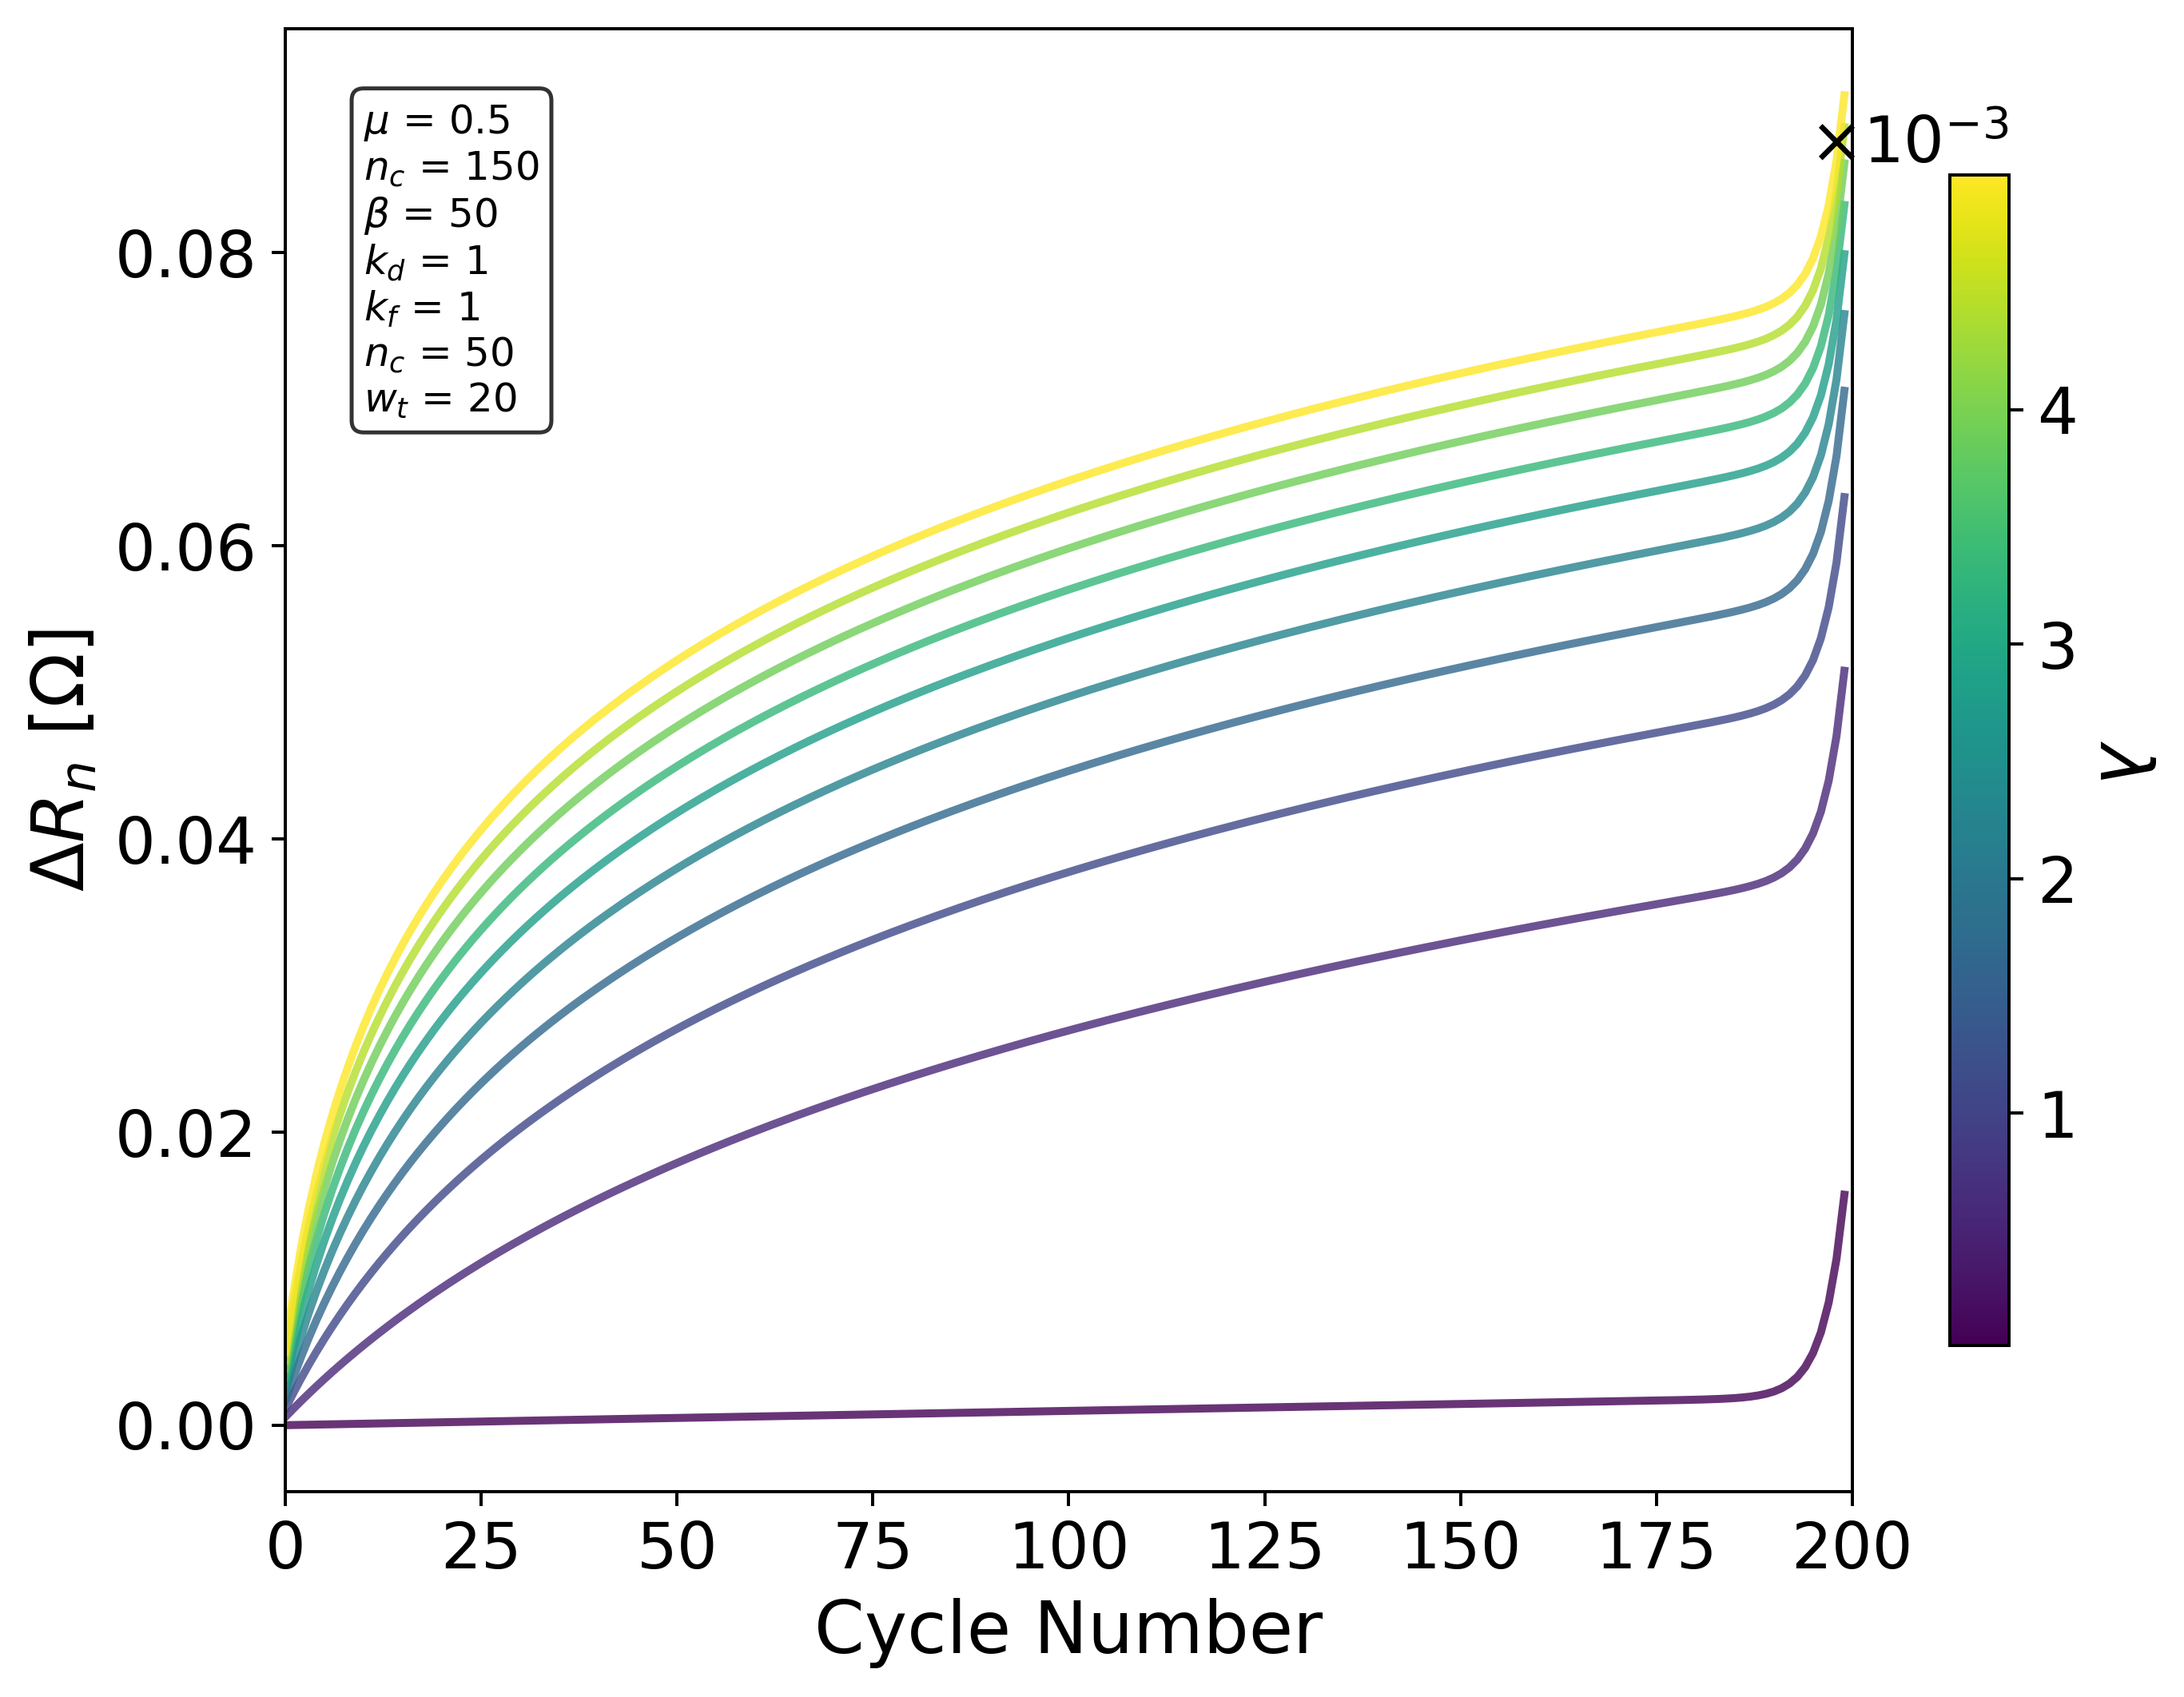

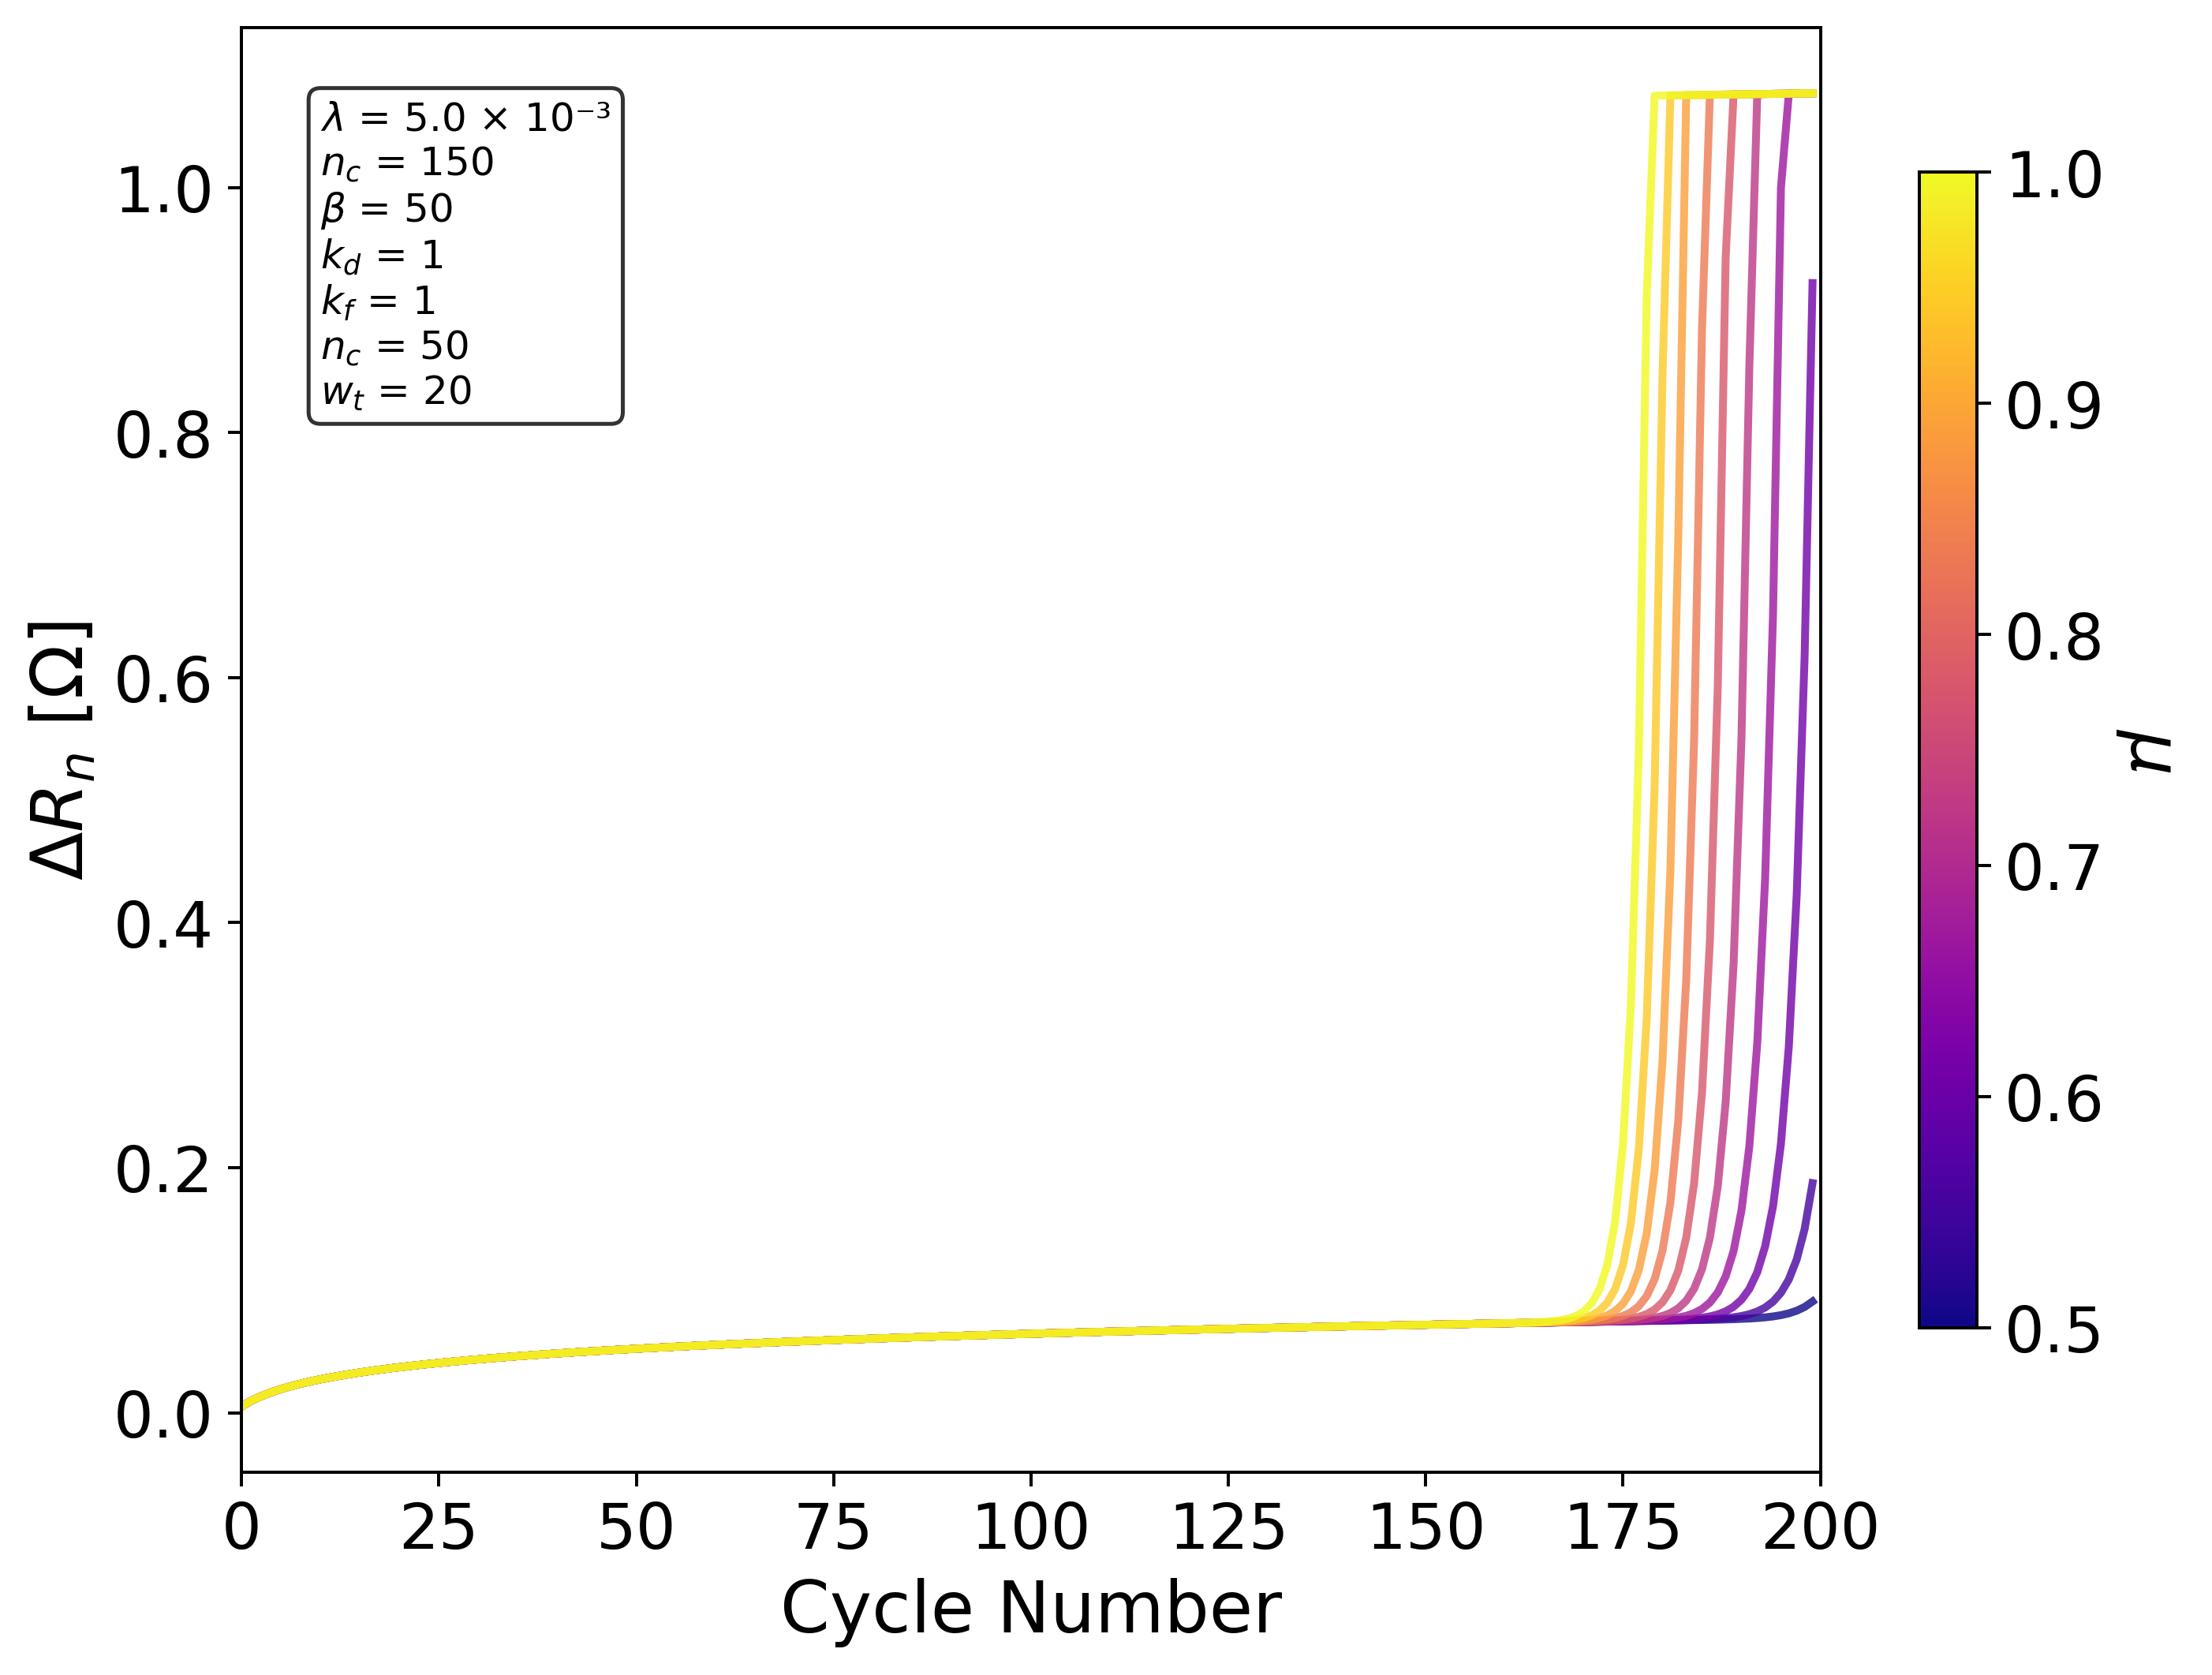

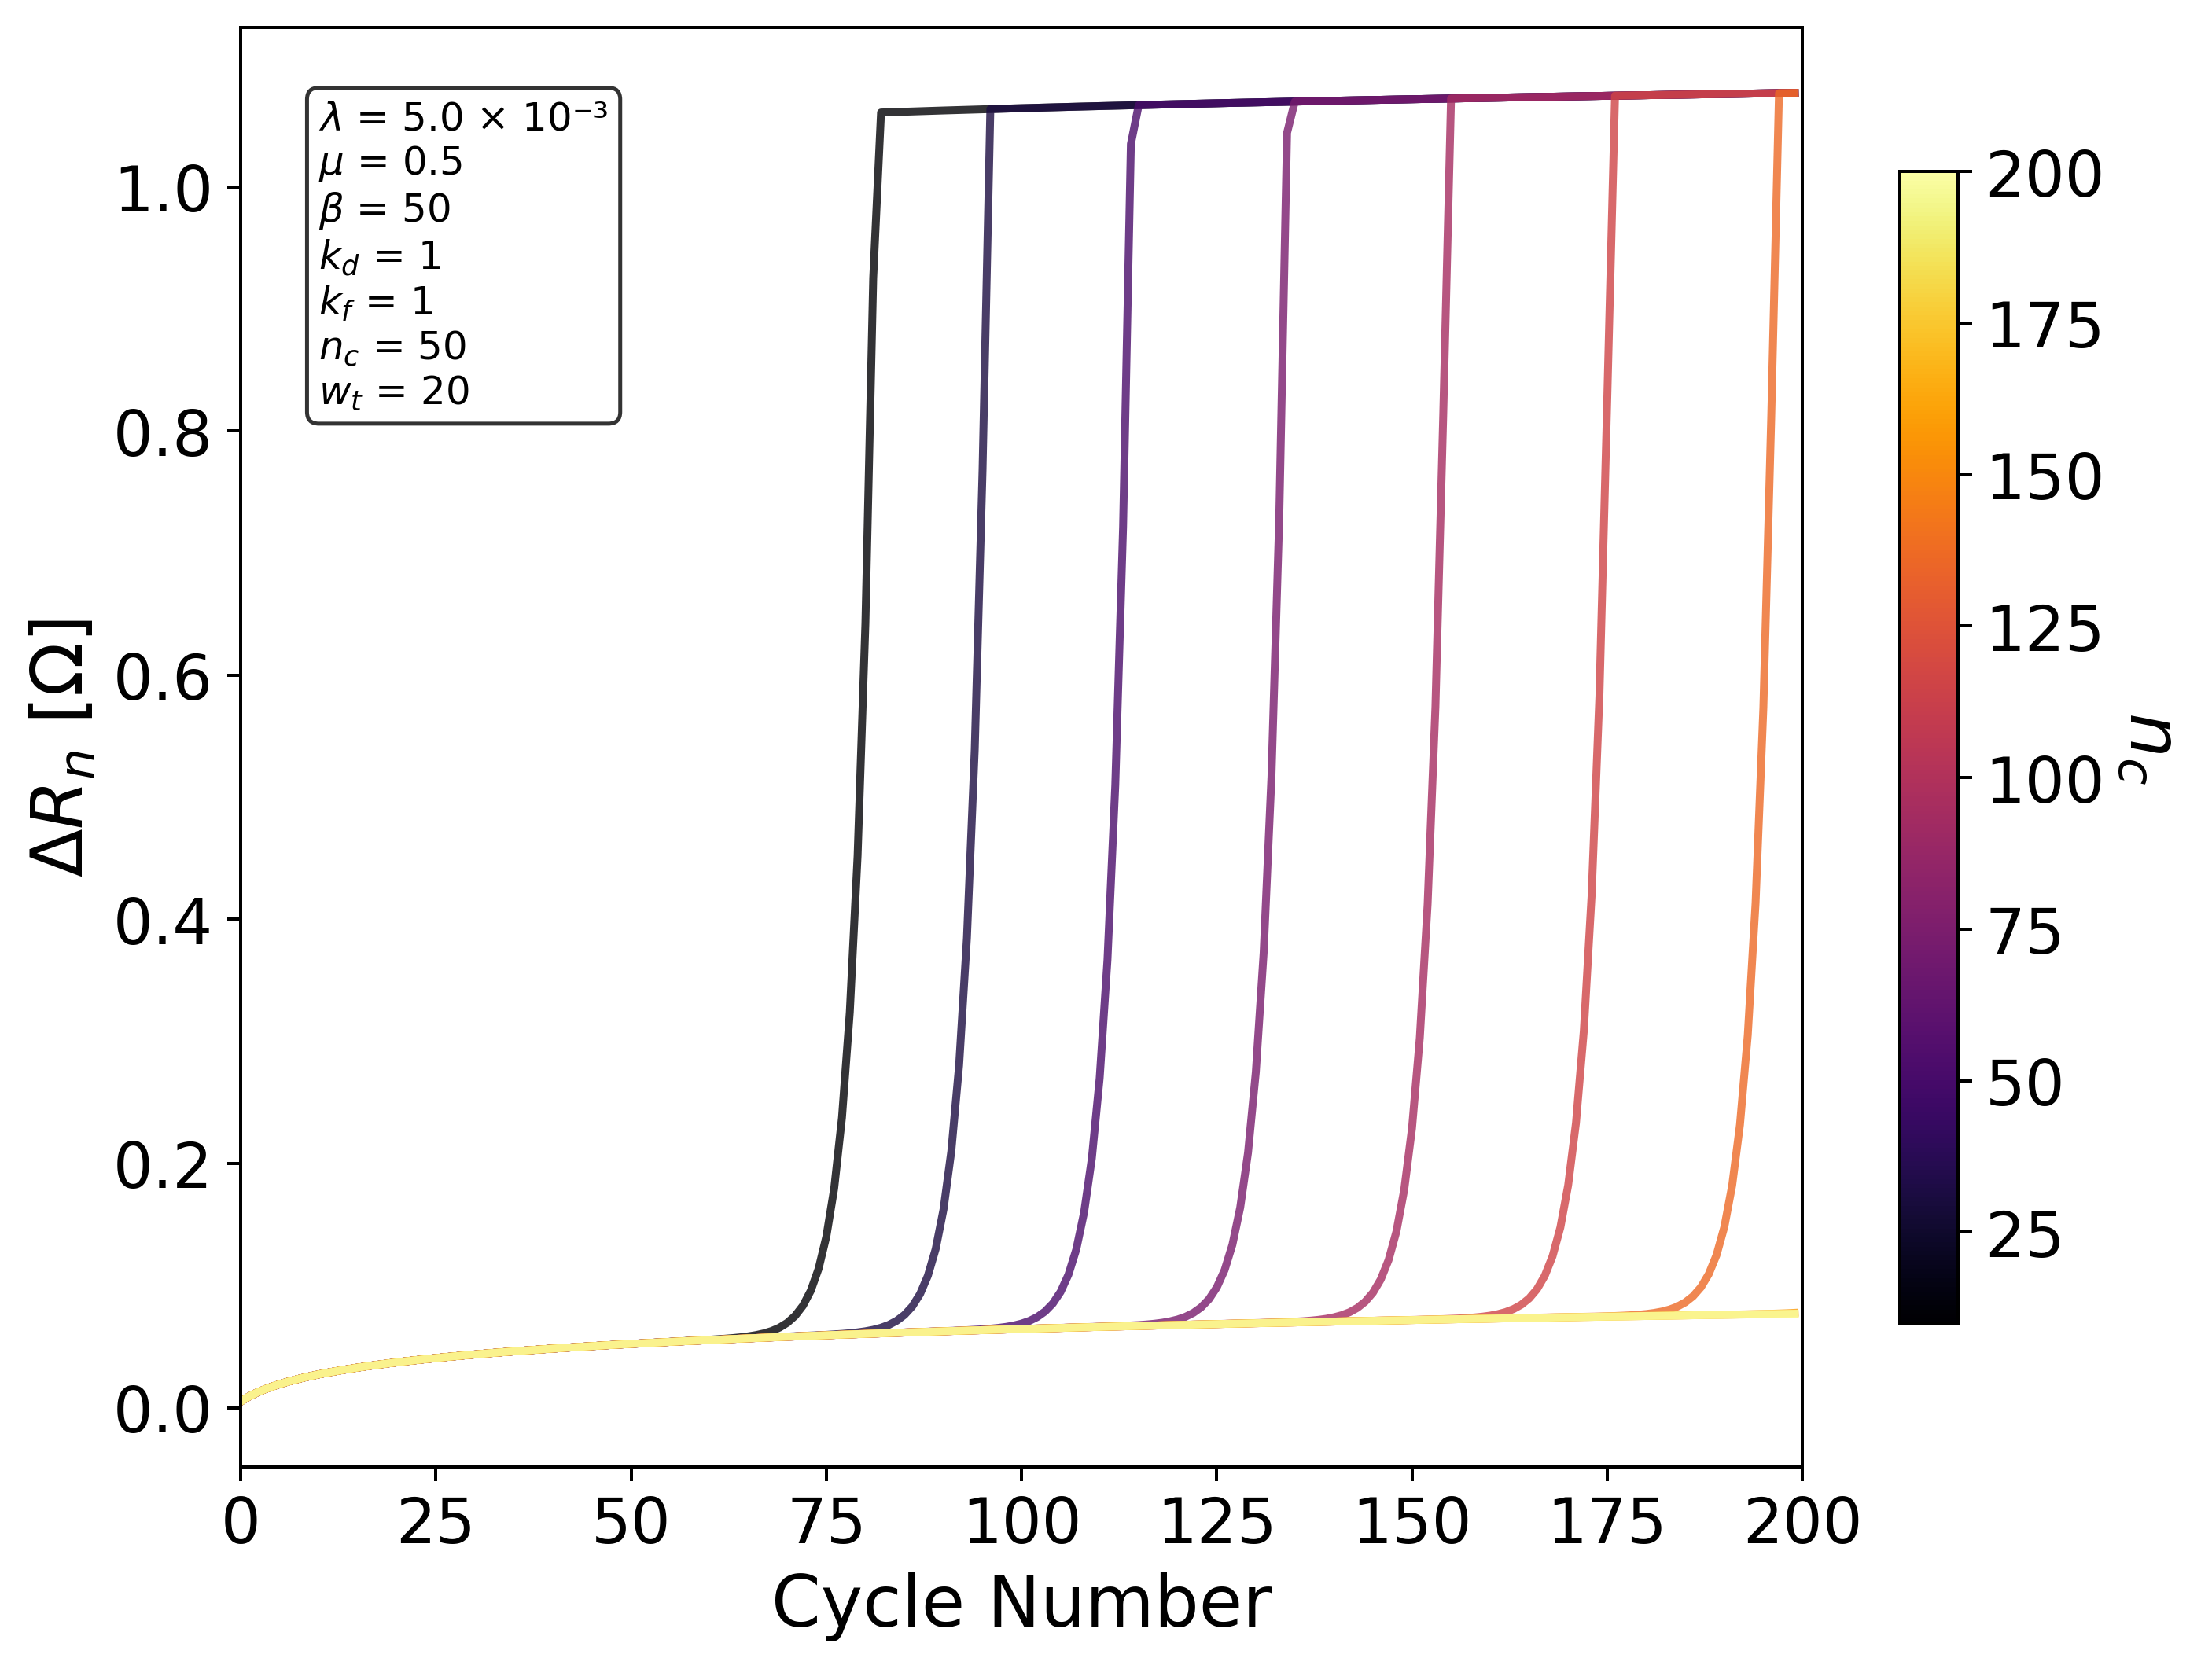

In [11]:
param_config = {
    "lam": {"base": 0.005, "span": (0.00001, 0.005)},
    "mu": {"base": 0.5, "span": (0.5, 1)},
    "n_c": {"base": 150, "span": (10, 200)}
}
fixed_params = {"N": 200, "beta": 50, "k_d": 1, "k_f": 1, "n_c": 50, "w_t": 20}
plot_parameter_sweeps(FractureIST, param_config, fixed_params)

Saved plot to: figures/sweep_lam.pdf


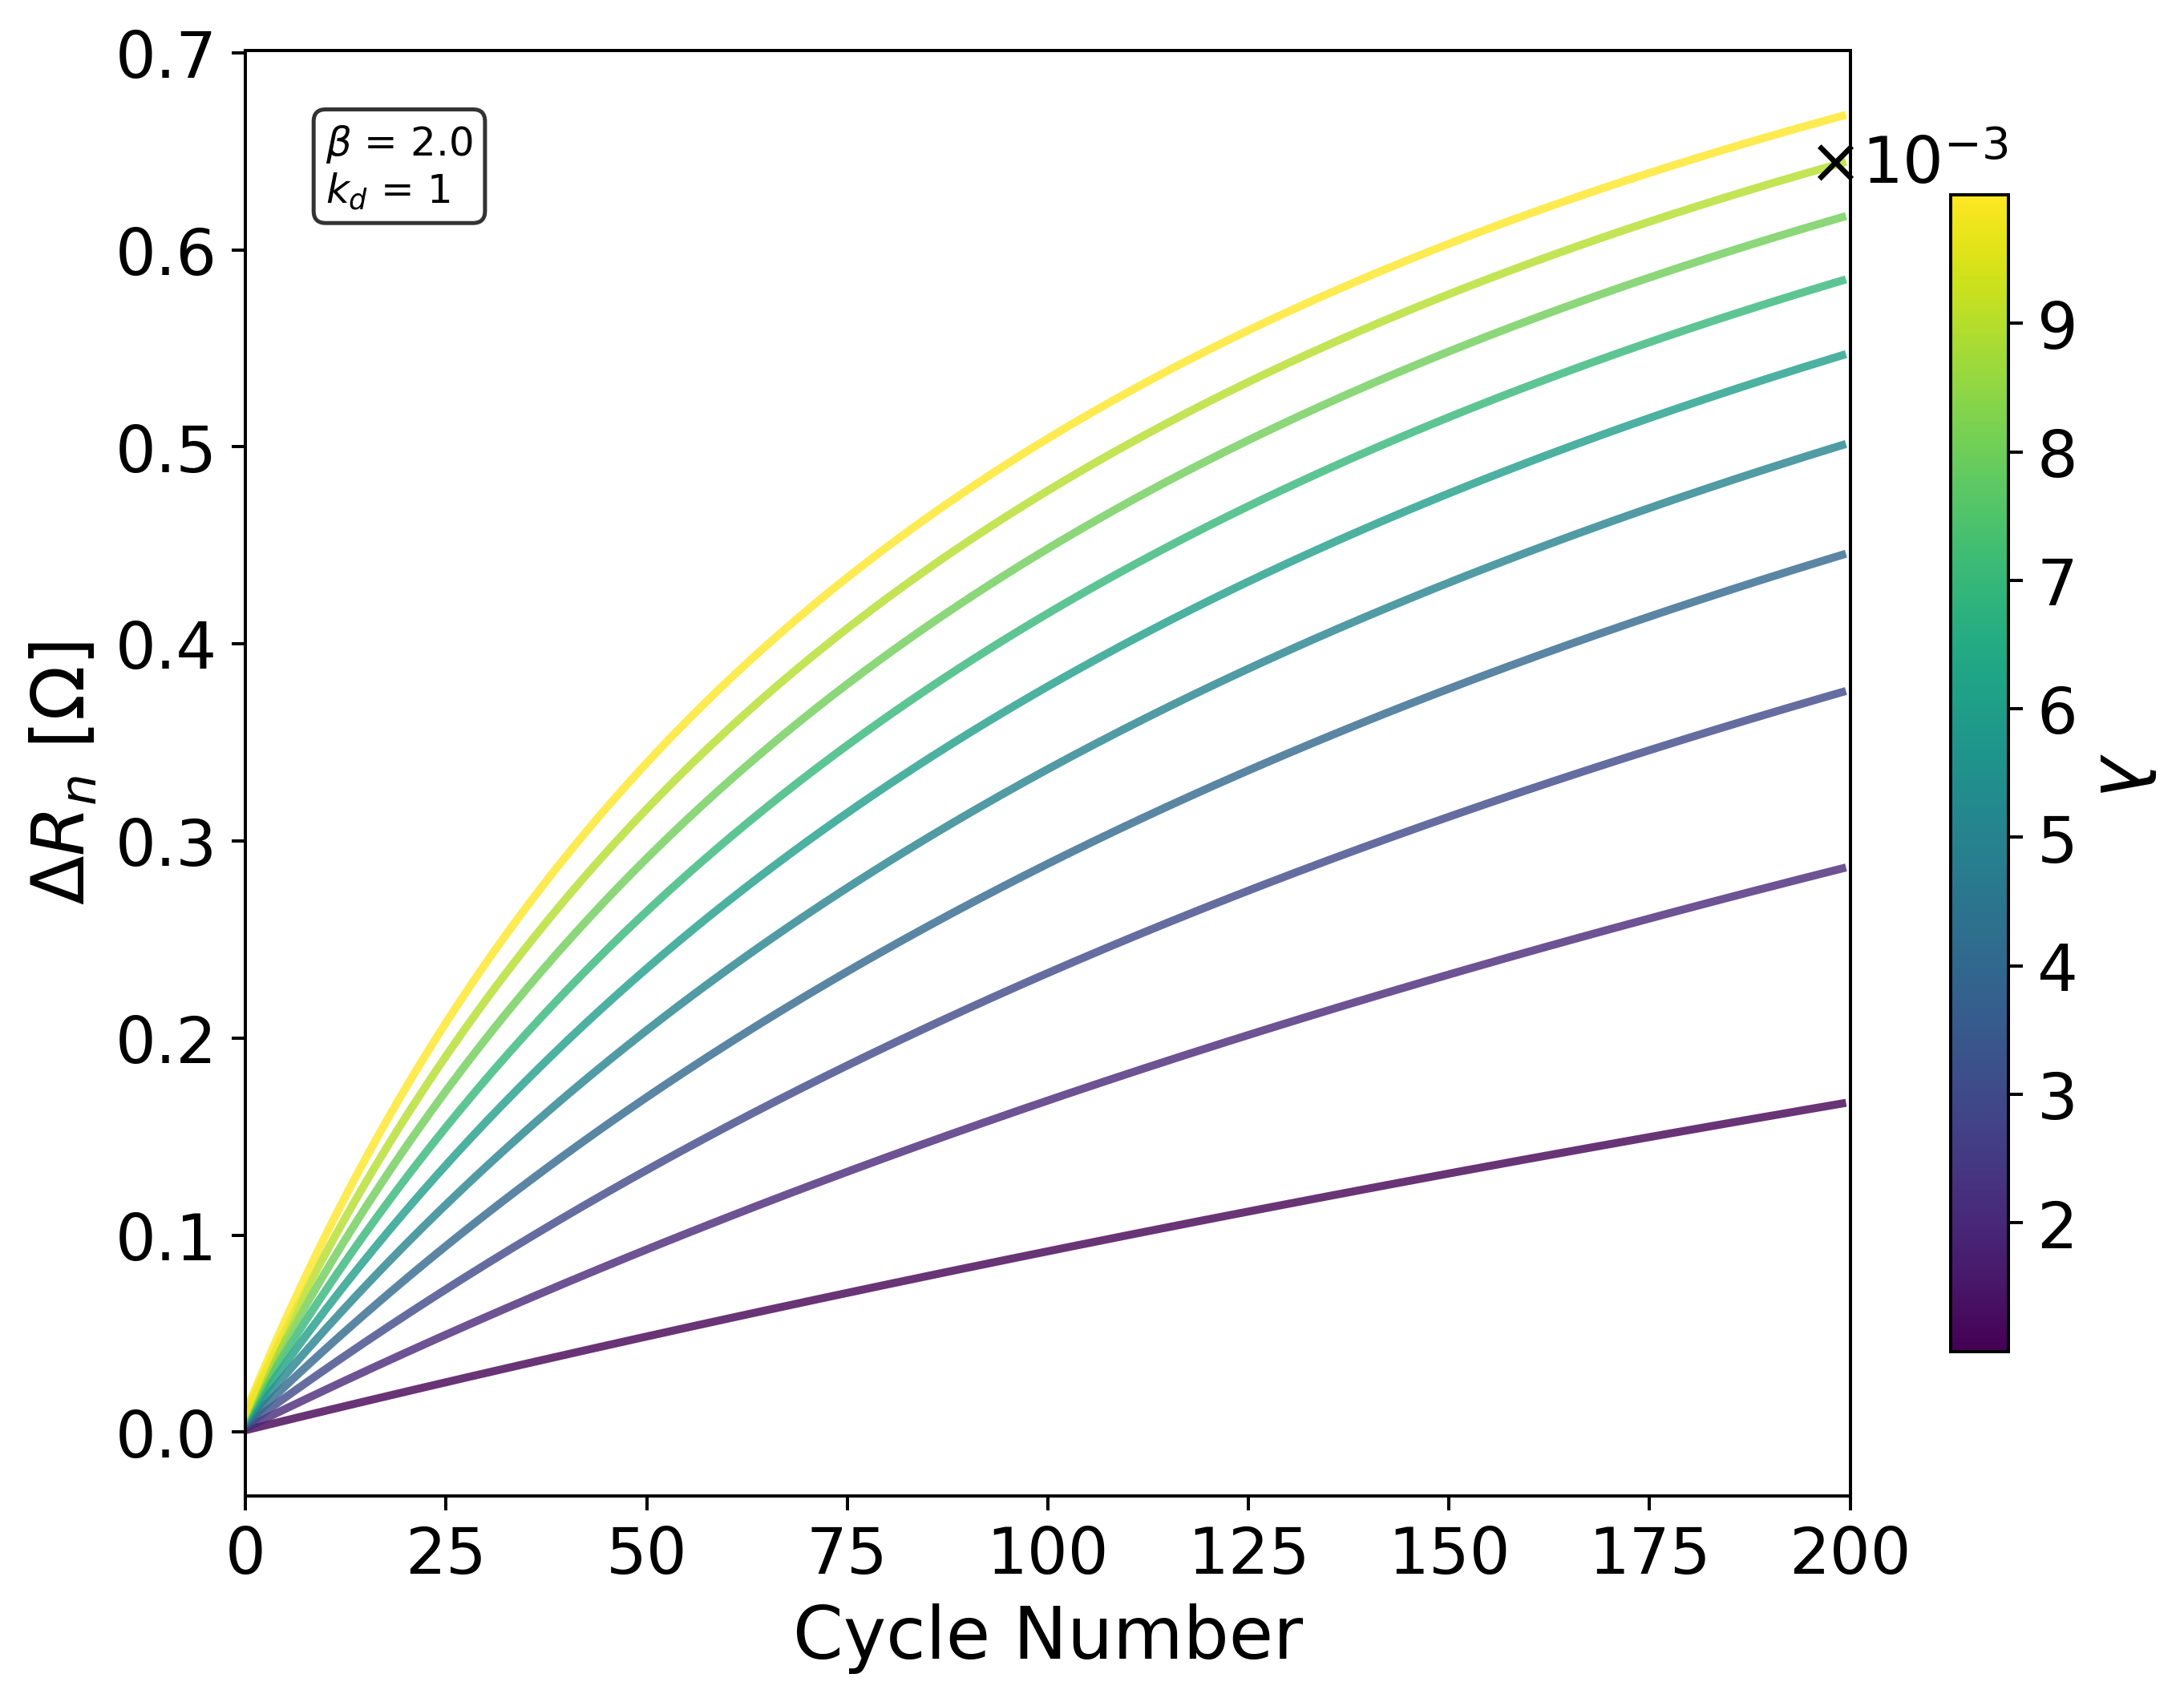

Saved plot to: figures/sweep_beta.pdf


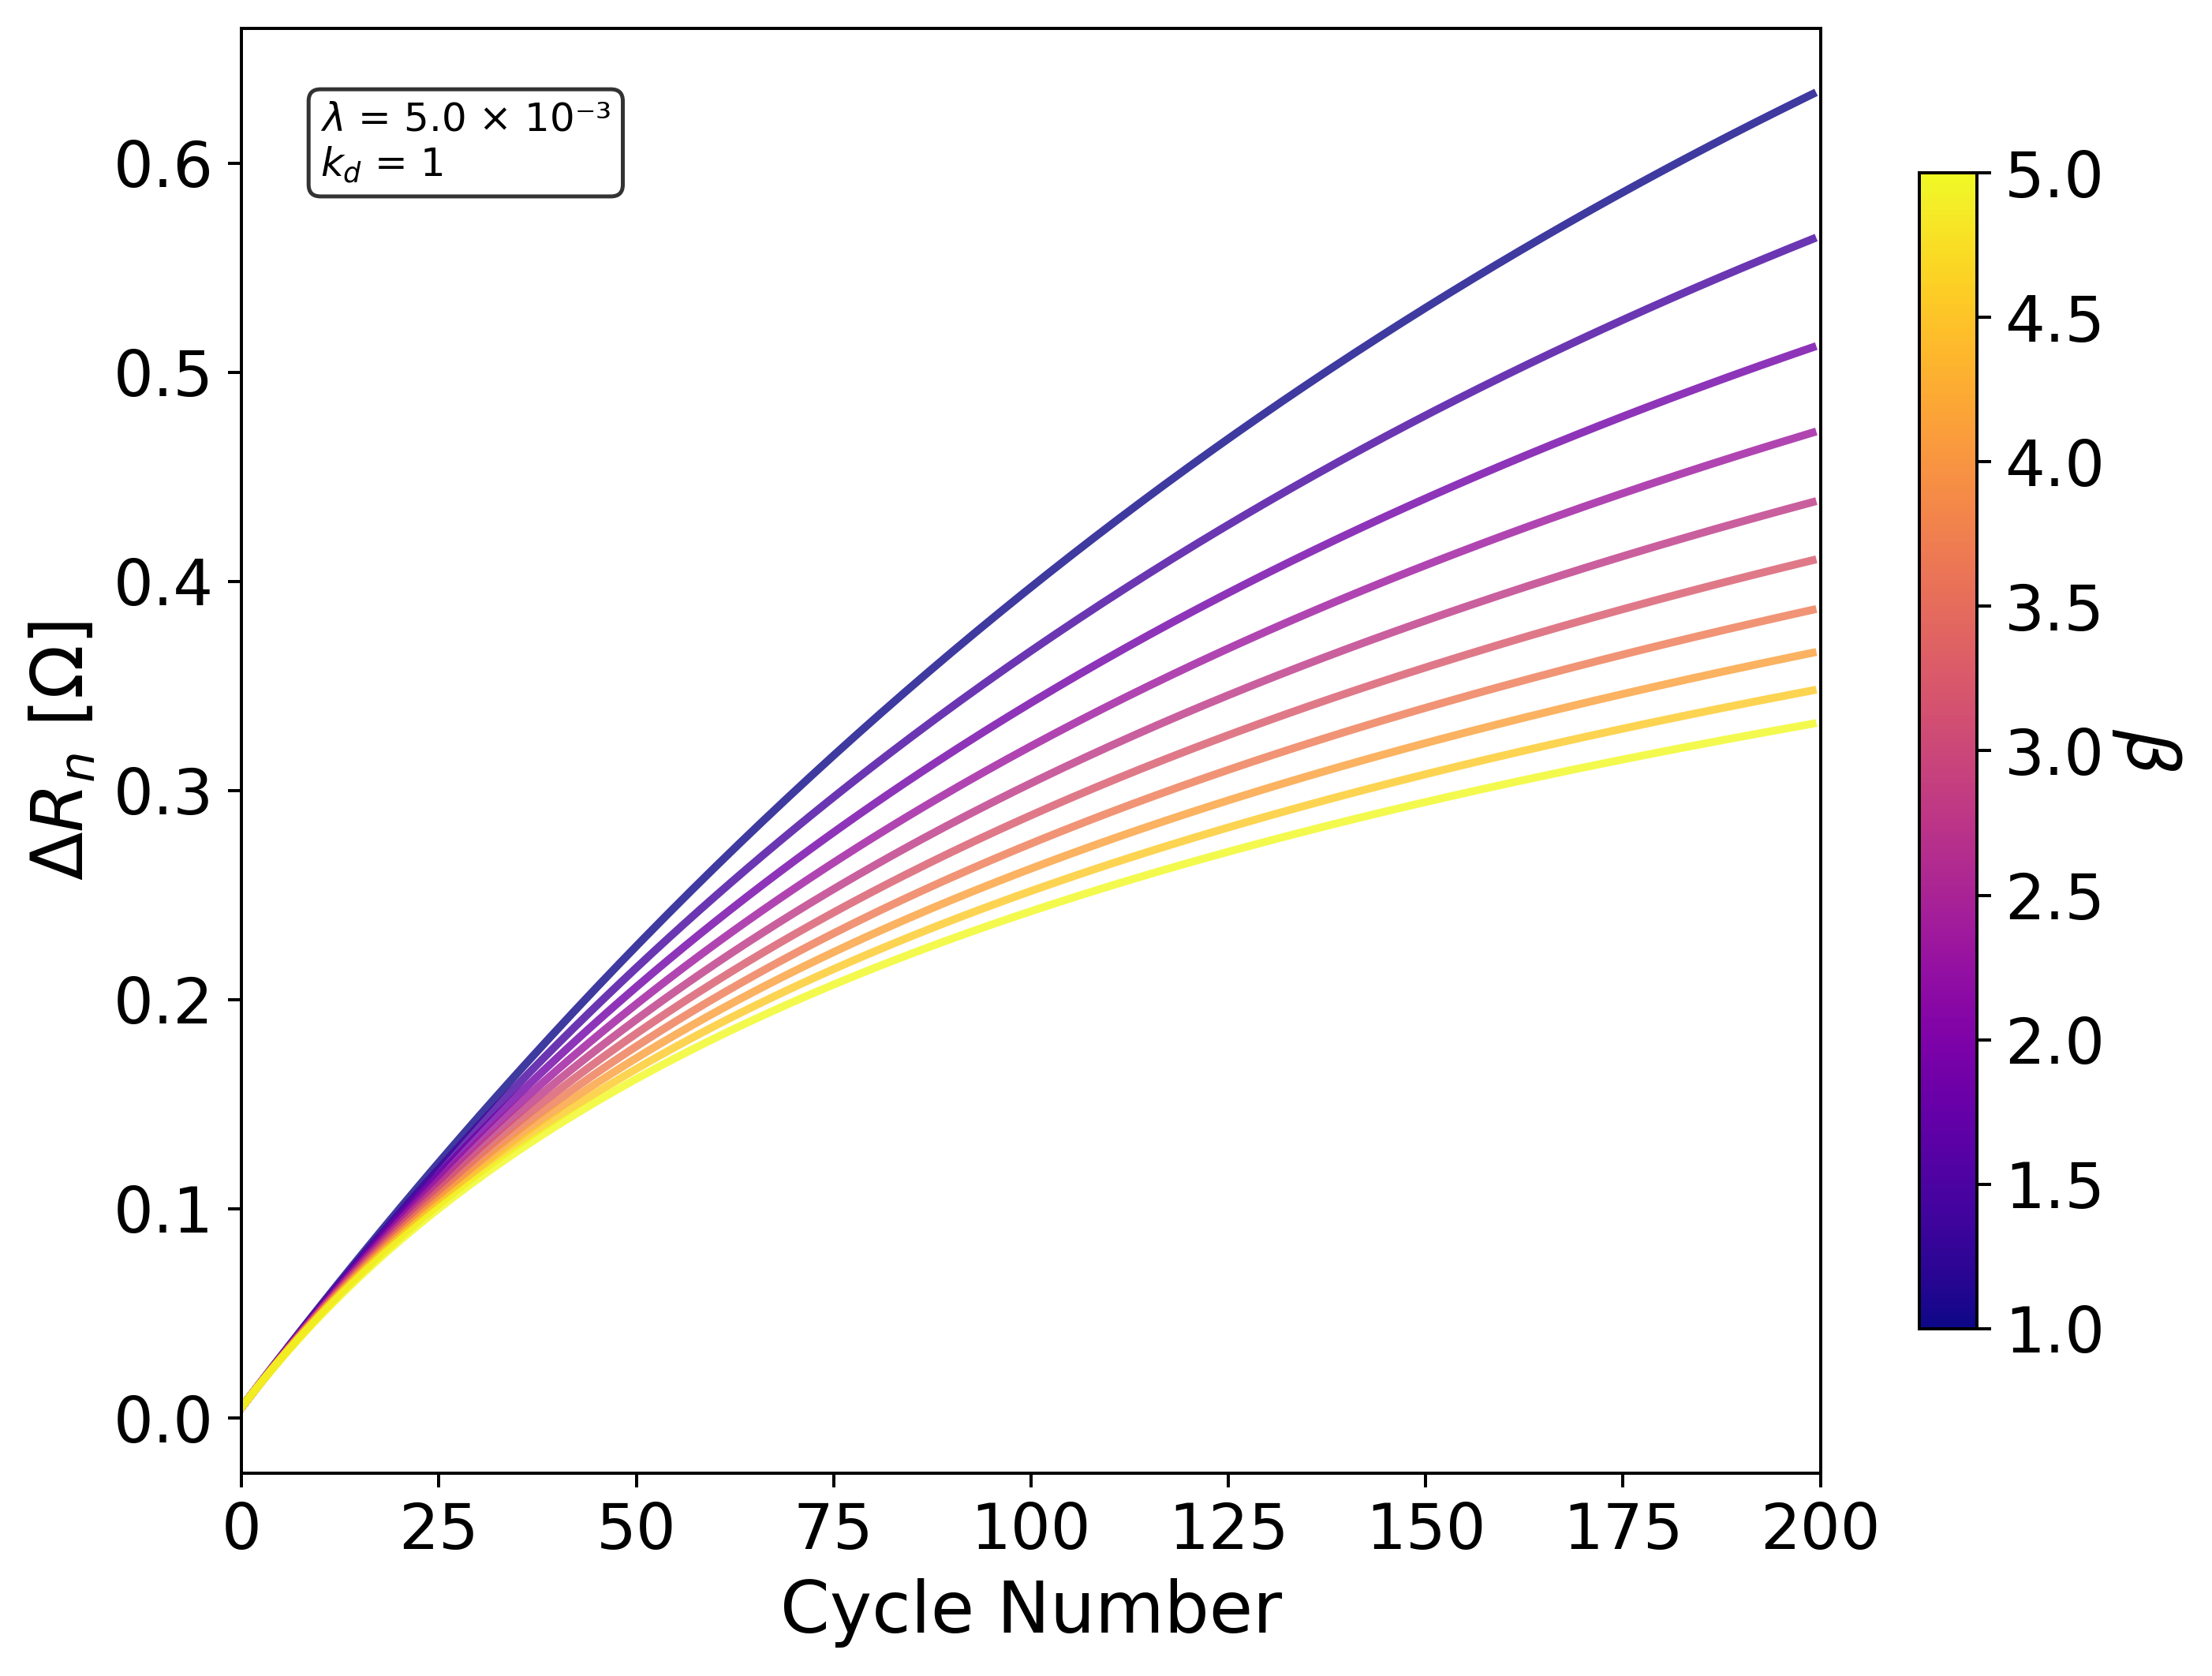

In [12]:
param_config = {
    "lam": {"base": 0.005, "span": (0.001, 0.01)},
    "beta": {"base": 2.0, "span": (1.0, 5.0)}
}
fixed_params = {"k_d":1, "N": 200}
plot_parameter_sweeps(DuctileIST, param_config, fixed_params, save_path='figures/')